<a href="https://colab.research.google.com/github/Gina-Kuo/NTHU_2025_DLIA_HW/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


## A. Checking and Preprocessing

In [11]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive
'「Attempt1.ipynb」的副本 的副本'
 「Attempt2_CC.ipynb」
'「Attempt3.ipynb '
 「Attempt4CC.ipynb」
 bottle
'Deep Learning for Industrial Application'
 「HW3.ipynb」的副本
'lab2_1 (1).ipynb'
 「lab2-1.ipynb」的副本
 lab4.ipynb
'lab4.ipynb 的副本'
 model_classification_mobilenetv2.pth
 nvda.us.txt


In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

#  Load Dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nvda.us.txt')
print(df.head())
df = df[['Date', 'Close']]
df = df.dropna()
print(df.head())

         Date    Open    High     Low   Close    Volume  OpenInt
0  1999-01-22  1.6238  1.8092  1.4379  1.5215  18297633        0
1  1999-01-25  1.6423  1.6980  1.5215  1.6793   3445279        0
2  1999-01-26  1.6980  1.7350  1.5311  1.5494   2320993        0
3  1999-01-27  1.5586  1.5957  1.4660  1.5494   1662658        0
4  1999-01-28  1.5494  1.5586  1.5311  1.5401   1540110        0
         Date   Close
0  1999-01-22  1.5215
1  1999-01-25  1.6793
2  1999-01-26  1.5494
3  1999-01-27  1.5494
4  1999-01-28  1.5401


In [13]:
# Normalize the 'Close' price
close_prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
close_prices_scaled = scaler.fit_transform(close_prices)
df['Close_scaled'] = close_prices_scaled
dates = df['Date'].values

In [14]:
# Check data summary
print("Data columns:\n", df.columns)
print(" Data types and info:")
print(df.info())
print(" Null values:\n", df.isnull().sum())
print(" Data shape:", df.shape)
print("Descriptive stats:\n", df.describe())

Data columns:
 Index(['Date', 'Close', 'Close_scaled'], dtype='object')
 Data types and info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4733 non-null   object 
 1   Close         4733 non-null   float64
 2   Close_scaled  4733 non-null   float64
dtypes: float64(2), object(1)
memory usage: 111.1+ KB
None
 Null values:
 Date            0
Close           0
Close_scaled    0
dtype: int64
 Data shape: (4733, 3)
Descriptive stats:
              Close  Close_scaled
count  4733.000000   4733.000000
mean     20.805404      0.090952
std      30.263705      0.140841
min       1.261900      0.000000
25%       7.978900      0.031260
50%      12.990000      0.054580
75%      19.106000      0.083043
max     216.140000      1.000000


In [15]:
# View a sample of the processed DataFrame
df[['Date', 'Close', 'Close_scaled']].head()

,Date,Close,Close_scaled
0,1999-01-22,1.5215,0.001208
1,1999-01-25,1.6793,0.001942
2,1999-01-26,1.5494,0.001338
3,1999-01-27,1.5494,0.001338
4,1999-01-28,1.5401,0.001295


In [16]:
#Try 3 combinations:
#(window=15, step=3) (window=30, step=5) (window=60, step=10)

import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, num_layers=1, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

 # Sequence generator
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:i + window_size])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)


# Training function
def train_model(X, y, window_size, step):
    # Create sequence
    X_seq, y_seq = create_sequences(X, y, window_size, step)

    # Split 80/20
    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    # Convert to torch tensors
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float().unsqueeze(1)
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float().unsqueeze(1)

    # Model
    model = LSTMModel(input_dim=X_train.shape[2], hidden_dim=50, num_layers=1, output_dim=1)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()

    # Test
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        mse = mean_squared_error(y_test.numpy(), y_pred.numpy())
    return mse

# Run 3 experiments
X_data = df[['Close_scaled']].values
y_data = df['Close_scaled'].values

results = []
configs = [(15, 3), (30, 5), (60, 10)]

for window, step in configs:
    mse = train_model(X_data, y_data, window, step)
    results.append((window, step, mse))

# Display results
mse_df = pd.DataFrame(results, columns=['Window Size', 'Step Size', 'Test MSE'])
print(mse_df)

   Window Size  Step Size  Test MSE
0           15          3  0.001433
1           30          5  0.086222
2           60         10  0.003356


In [17]:
# @title 預設標題文字
# Include 'Volume'
# For Question 2(i): Test with Volume added
# Reload only Close & Volume
df_vol = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nvda.us.txt')
df_vol = df_vol[['Date', 'Close', 'Volume']].dropna()

# Normalize both
scaler_close = MinMaxScaler()
scaler_volume = MinMaxScaler()
df_vol['Close_scaled'] = scaler_close.fit_transform(df_vol['Close'].values.reshape(-1, 1))
df_vol['Volume_scaled'] = scaler_volume.fit_transform(df_vol['Volume'].values.reshape(-1, 1))

# Use both features for input, still predict Close
X_data_multi = df_vol[['Close_scaled', 'Volume_scaled']].values
y_data_multi = df_vol['Close_scaled'].values

# Reuse your train_model function (window=10, step=2 from best config)
mse_with_volume = train_model(X_data_multi, y_data_multi, window_size=30, step=5)

print(f"MSE with Volume added: {mse_with_volume:.6f}")

MSE with Volume added: 0.010984


In [18]:
#Try different input feature combinations (e.g.,Close,Volume, Open, High, Low).
#  Explore best feature combination
# Reload all necessary features
df_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nvda.us.txt')
df_all = df_all[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Normalize everything
scalers = {}
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    scaler = MinMaxScaler()
    df_all[f'{col}_scaled'] = scaler.fit_transform(df_all[col].values.reshape(-1, 1))
    scalers[col] = scaler

# Define combos to test
feature_sets = {
    'Close only': ['Close_scaled'],
    'Close + Volume': ['Close_scaled', 'Volume_scaled'],
    'Open + High + Low': ['Open_scaled', 'High_scaled', 'Low_scaled'],
    'OHL + Close': ['Open_scaled', 'High_scaled', 'Low_scaled', 'Close_scaled'],
    'All features': ['Open_scaled', 'High_scaled', 'Low_scaled', 'Close_scaled', 'Volume_scaled']
}

results_q2ii = []

for label, features in feature_sets.items():
    X = df_all[features].values
    y = df_all['Close_scaled'].values  # Always predict Close
    mse = train_model(X, y, window_size=30, step=5)
    results_q2ii.append((label, features, mse))

# Show table
results_q2ii_df = pd.DataFrame(results_q2ii, columns=["Feature Set", "Features Used", "Test MSE"])
results_q2ii_df = results_q2ii_df.sort_values(by='Test MSE')
print(results_q2ii_df)

         Feature Set                                      Features Used  \
4       All features  [Open_scaled, High_scaled, Low_scaled, Close_s...   
1     Close + Volume                      [Close_scaled, Volume_scaled]   
2  Open + High + Low             [Open_scaled, High_scaled, Low_scaled]   
3        OHL + Close  [Open_scaled, High_scaled, Low_scaled, Close_s...   
0         Close only                                     [Close_scaled]   

   Test MSE  
4  0.000440  
1  0.001152  
2  0.001327  
3  0.004377  
0  0.007942  


In [19]:
#  Compare Normalized vs Raw Inputs

# Reload original data
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nvda.us.txt')
df_raw = df_raw[['Date', 'Close']].dropna()

# Prepare raw input (without scaling)
X_raw = df_raw[['Close']].values
y_raw = df_raw['Close'].values

# Prepare normalized input (already have: X_norm, y_norm)
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X_raw)
y_norm = scaler.fit_transform(y_raw.reshape(-1, 1)).flatten()

# Train model with normalized input
mse_norm = train_model(X_norm, y_norm, window_size=30, step=5)

# Train model with raw input
mse_raw = train_model(X_raw, y_raw, window_size=30, step=5)

# Compare
print(f"Normalized MSE: {mse_norm:.6f}")
print(f"Raw Input MSE: {mse_raw:.6f}")

Normalized MSE: 0.007237
Raw Input MSE: 5444.394043


#### Visualizing the model performance

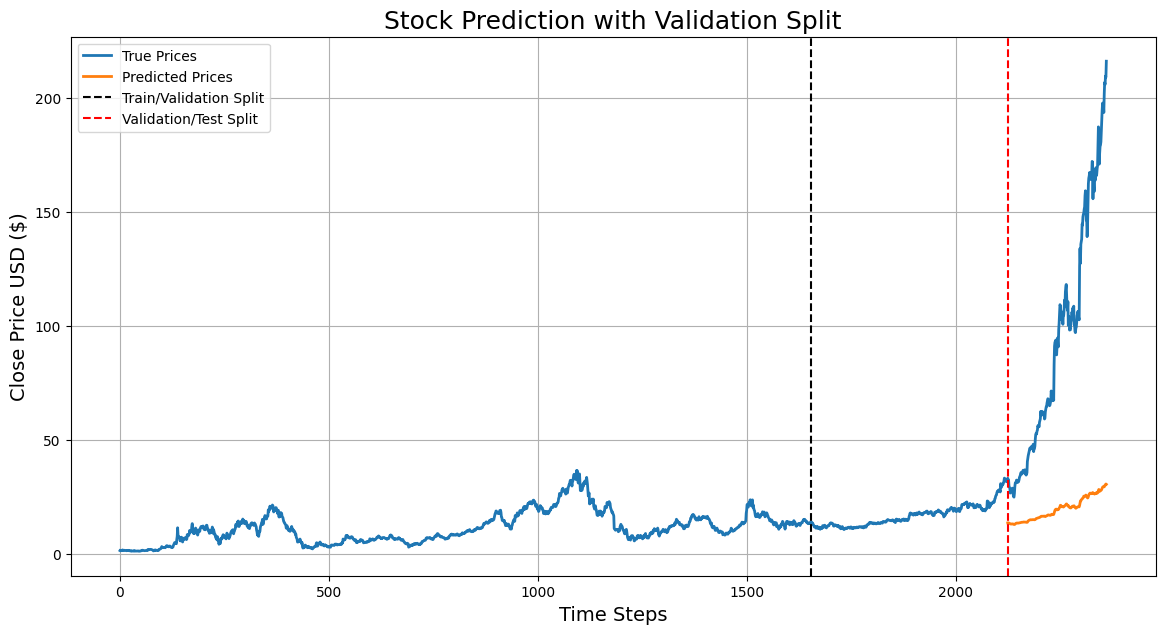

In [20]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, num_layers=1, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take last time step
        return out

# Sequence generator
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:i + window_size])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

# Modify train_model to also split train/val/test
def train_model_split(X, y, window_size, step):
    X_seq, y_seq = create_sequences(X, y, window_size, step)

    train_size = int(0.7 * len(X_seq))  # 70% train
    val_size = int(0.2 * len(X_seq))    # 20% val
    test_size = len(X_seq) - train_size - val_size

    X_train = X_seq[:train_size]
    y_train = y_seq[:train_size]
    X_val = X_seq[train_size:train_size+val_size]
    y_val = y_seq[train_size:train_size+val_size]
    X_test = X_seq[train_size+val_size:]
    y_test = y_seq[train_size+val_size:]

    # Fix shape
    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    model = LSTMModel(input_dim=X_train.shape[2], hidden_dim=50, num_layers=1, output_dim=1)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        mse = mean_squared_error(y_test.numpy(), y_pred.numpy())

    return model, X_train, y_train, X_val, y_val, X_test, y_test, mse


# Plot function
def plot_with_validation(X_train, y_train, X_val, y_val, X_test, y_test, model, scaler, title="Stock Prediction with Validation Split"):
    model.eval()

    # Predict
    with torch.no_grad():
        y_pred = model(X_test)

    y_train = y_train.numpy()
    y_val = y_val.numpy()
    y_test = y_test.numpy()
    y_pred = y_pred.numpy()

    # Inverse transform
    y_train_inv = scaler.inverse_transform(y_train)
    y_val_inv = scaler.inverse_transform(y_val)
    y_test_inv = scaler.inverse_transform(y_test)
    y_pred_inv = scaler.inverse_transform(y_pred)

    # Prepare full length
    total_len = len(y_train_inv) + len(y_val_inv) + len(y_pred_inv)
    true_prices = np.concatenate([y_train_inv.flatten(), y_val_inv.flatten(), y_test_inv.flatten()])
    predicted_prices = np.concatenate([np.full(len(y_train_inv), np.nan), np.full(len(y_val_inv), np.nan), y_pred_inv.flatten()])

    # Plot
    plt.figure(figsize=(14,7))
    plt.plot(true_prices, label="True Prices", linewidth=2)
    plt.plot(predicted_prices, label="Predicted Prices", linewidth=2)
    plt.axvline(x=len(y_train_inv), color='black', linestyle='--', label="Train/Validation Split")
    plt.axvline(x=len(y_train_inv)+len(y_val_inv), color='red', linestyle='--', label="Validation/Test Split")
    plt.title(title, fontsize=18)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Close Price USD ($)', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()
# Prepare scaled X, y
scaler = MinMaxScaler()
X_data = scaler.fit_transform(df[['Close']].values)
y_data = scaler.transform(df[['Close']].values)

# Train
model, X_train, y_train, X_val, y_val, X_test, y_test, mse = train_model_split(X_data, y_data, window_size=10, step=2)

# Plot
plot_with_validation(X_train, y_train, X_val, y_val, X_test, y_test, model, scaler)

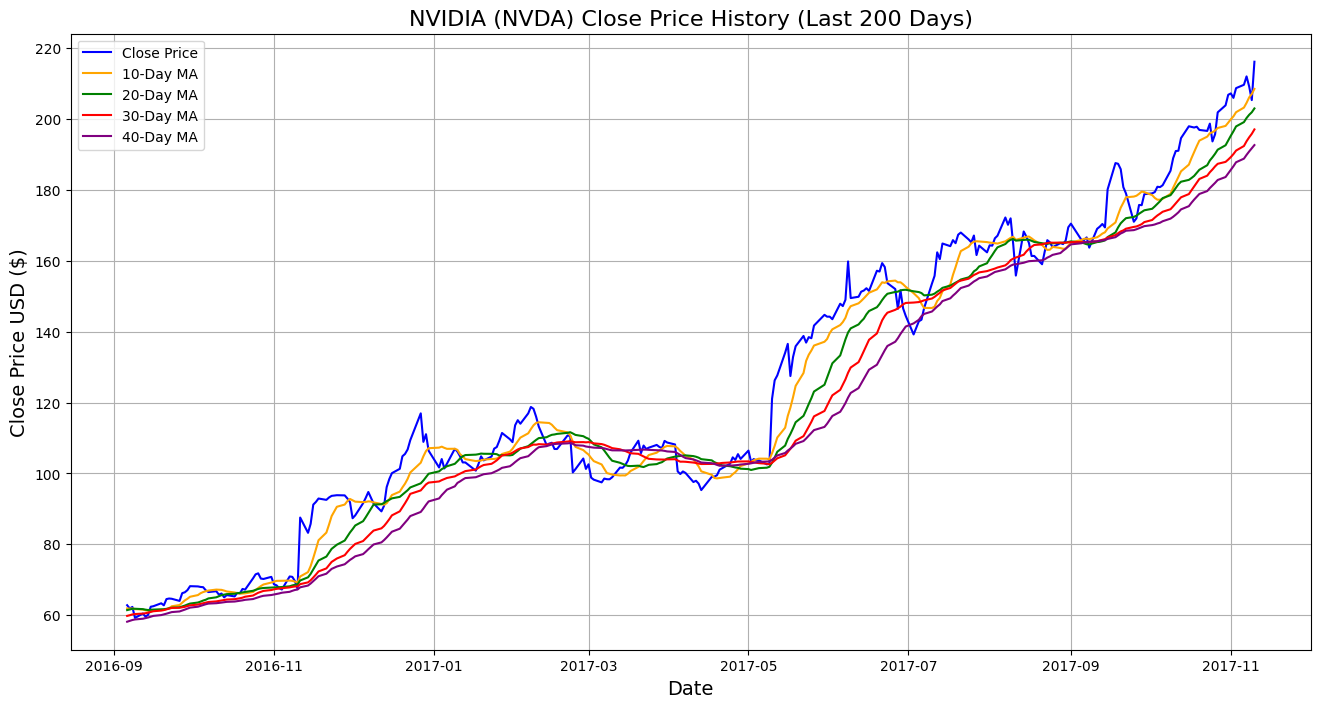

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload Close Price
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nvda.us.txt')
df = df[['Date', 'Close']].dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create moving averages
df_10 = pd.DataFrame()
df_20 = pd.DataFrame()
df_30 = pd.DataFrame()
df_40 = pd.DataFrame()

df_10['Close'] = df['Close'].rolling(window=10).mean()
df_20['Close'] = df['Close'].rolling(window=20).mean()
df_30['Close'] = df['Close'].rolling(window=30).mean()
df_40['Close'] = df['Close'].rolling(window=40).mean()

# Only plot last 300 days
plt.figure(figsize=(16,8))
plt.plot(df['Close'].tail(300), label='Close Price', color='blue')
plt.plot(df_10['Close'].tail(300), label='10-Day MA', color='orange')
plt.plot(df_20['Close'].tail(300), label='20-Day MA', color='green')
plt.plot(df_30['Close'].tail(300), label='30-Day MA', color='red')
plt.plot(df_40['Close'].tail(300), label='40-Day MA', color='purple')

plt.title('NVIDIA (NVDA) Close Price History (Last 200 Days)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()